In [1]:
import os
import xarray as xr
import numpy as np
from statistics import NormalDist
import statsmodels.api as smapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(style='ticks',font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")

In [2]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'agottlieb','snow_nonlinearity')
data_dir = os.path.join(project_dir,'data','processed')

In [3]:
ims = xr.open_dataset(os.path.join(data_dir,'ims_24km','wy_sc.nc')).sel(time=slice("1998","2022")) # water years 1999-2023
era5 = xr.open_dataset(os.path.join(data_dir,'era5','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
era5['cold_days'] = 151-era5['warm_days'].clip(max=151)
era5['cold_frac'] = era5['cold_days']/151
sc_mask = (ims['sc'].median("time")>30) # keep placs with snow cover in >3/4 years
ims = ims.where(sc_mask)
era5 = era5.where(sc_mask)
era5['tavg_clim'] = era5['tavg'].mean("time")
era5['tavg_anom'] = era5['tavg']-era5['tavg'].mean("time")
era5['cold_days_anom'] = era5['cold_days']-era5['cold_days'].mean("time")
ims['sc_anom'] = ims['sc']-ims['sc'].mean("time")

In [4]:
era5_df = xr.merge([era5[['tavg','tavg_clim','tavg_anom','cold_days','cold_days_anom','cold_frac']],ims]).to_dataframe().dropna()
ts = np.arange(-36,6,0.5)
era5_cold_means = []
era5_cold_stds = []
for t in ts:
    _cold = era5_df[(era5_df['tavg_clim']>t-2.5)&(era5_df['tavg_clim']<=t+2.5)]['cold_frac'] # rolling 5-degree temperature window
    era5_cold_means.append(_cold.mean())
    era5_cold_stds.append(_cold.std())
era5_cold_means = np.array(era5_cold_means)
era5_cold_stds = np.array(era5_cold_stds)
era5_cold_upper = (era5_cold_means+era5_cold_stds)
era5_cold_lower = (era5_cold_means-era5_cold_stds)

In [5]:
# anomalies in warm winters
era5_plus1_means = []
era5_plus2_means = []

for t in ts:
    # 0.5-1-5 above average
    _df1 = era5_df[(era5_df['tavg_clim']>t-2.5)&(era5_df['tavg_clim']<=t+2.5)&(era5_df['tavg_anom']>0.5)&(era5_df['tavg_anom']<=1.5)][['cold_days_anom','sc_anom']] 
    # 1.5-2.5 above average
    _df2 = era5_df[(era5_df['tavg_clim']>t-2.5)&(era5_df['tavg_clim']<=t+2.5)&(era5_df['tavg_anom']>1.5)&(era5_df['tavg_anom']<=2.5)][['cold_days_anom','sc_anom']]
    era5_plus1_means.append(_df1.mean())
    era5_plus2_means.append(_df2.mean())

era5_plus1_means = pd.concat(era5_plus1_means,axis=1).transpose()
era5_plus2_means = pd.concat(era5_plus2_means,axis=1).transpose()
era5_plus1_means.index=ts
era5_plus2_means.index=ts


In [6]:
snotel_ds = xr.open_dataset(os.path.join(data_dir,'snotel','ndjfm_stats.nc'))
ecad_ds = xr.open_dataset(os.path.join(data_dir,'ecad','ndjfm_stats.nc'))
ghcnd_ds = xr.open_dataset(os.path.join(data_dir,'ghcnd','ndjfm_stats.nc'))
insitu_ds = xr.concat([snotel_ds,ecad_ds,ghcnd_ds],dim='site').sel(time=slice("1998","2022"))
insitu_ds = insitu_ds.where(insitu_ds['wy_sc'].median("time")>30,drop=True)
insitu_ds = insitu_ds.where((insitu_ds['wy_sc'].count("time")>=20)&(insitu_ds['tavg'].count("time")>=20),drop=True)
insitu_ds['cold_frac']=1-insitu_ds['warm_days_tavg']/151
insitu_ds['cold_days']=151-insitu_ds['warm_days_tavg']
insitu_ds['cold_days_anom'] = insitu_ds['cold_days']-insitu_ds['cold_days'].mean("time")
insitu_ds['sc_anom'] = insitu_ds['wy_sc']-insitu_ds['wy_sc'].mean("time")
insitu_ds['tavg_clim'] = insitu_ds['tavg'].mean("time")
insitu_ds['tavg_anom'] = insitu_ds['tavg']-insitu_ds['tavg_clim']
insitu_df = insitu_ds[['tavg_clim','tavg_anom','sc_anom','cold_frac','cold_days_anom','sc','cold_days']].to_dataframe()

In [7]:
insitu_cold_means = []
insitu_cold_stds = []
for t in ts:
    _cold = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)]['cold_frac']
    insitu_cold_means.append(_cold.mean())
    insitu_cold_stds.append(_cold.std())
insitu_cold_means = np.array(insitu_cold_means)
insitu_cold_stds = np.array(insitu_cold_stds)
insitu_cold_upper = (insitu_cold_means+insitu_cold_stds)
insitu_cold_lower = (insitu_cold_means-insitu_cold_stds)

In [8]:
insitu_plus1_means = []
insitu_plus2_means = []


for t in ts:
    _df1 = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)&(insitu_df['tavg_anom']>0.5)&(insitu_df['tavg_anom']<=1.5)][['cold_days_anom','sc_anom']]
    _df2 = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)&(insitu_df['tavg_anom']>1.5)&(insitu_df['tavg_anom']<=2.5)][['cold_days_anom','sc_anom']]
    if len(_df1)<20:
        _df1.loc[:] = np.nan
    insitu_plus1_means.append(_df1.mean())
    if len(_df2)<20:
        _df2.loc[:] = np.nan
    insitu_plus2_means.append(_df2.mean())
    

insitu_plus1_means = pd.concat(insitu_plus1_means,axis=1).transpose()
insitu_plus2_means = pd.concat(insitu_plus2_means,axis=1).transpose()
insitu_plus1_means.index=ts
insitu_plus2_means.index=ts


In [9]:
# sc anomalies as a function of cold day anomalies
era5_cold_sc_df = xr.merge([era5[['cold_days','cold_days_anom']],ims[['sc','sc_anom']]]).to_dataframe().dropna()
cold = np.arange(-40,41)
era5_cold_sc_means = []
era5_cold_sc_stds = []
for t in cold:
    _df = era5_cold_sc_df[(era5_cold_sc_df['cold_days_anom']>t-2.5)&(era5_cold_sc_df['cold_days_anom']<t+2.5)]['sc_anom'] # 5 cold-day moving window
    era5_cold_sc_means.append(_df.mean())
    era5_cold_sc_stds.append(_df.std())
    
era5_cold_sc_means = np.array(era5_cold_sc_means)
era5_cold_sc_stds = np.array(era5_cold_sc_stds)
era5_cold_sc_upper = (era5_cold_sc_means+era5_cold_sc_stds)
era5_cold_sc_lower = (era5_cold_sc_means-era5_cold_sc_stds)

In [10]:
insitu_cold_sc_means = []
insitu_cold_sc_stds = []
for t in cold:
    _df = insitu_df[(insitu_df['cold_days_anom']>t-2.5)&(insitu_df['cold_days_anom']<=t+2.5)]['sc_anom']
    insitu_cold_sc_means.append(_df.mean())
    insitu_cold_sc_stds.append(_df.std())
    
insitu_cold_sc_means = np.array(insitu_cold_sc_means)
insitu_cold_sc_stds = np.array(insitu_cold_sc_stds)
insitu_cold_sc_upper = (insitu_cold_sc_means+insitu_cold_sc_stds)
insitu_cold_sc_lower = (insitu_cold_sc_means-insitu_cold_sc_stds)

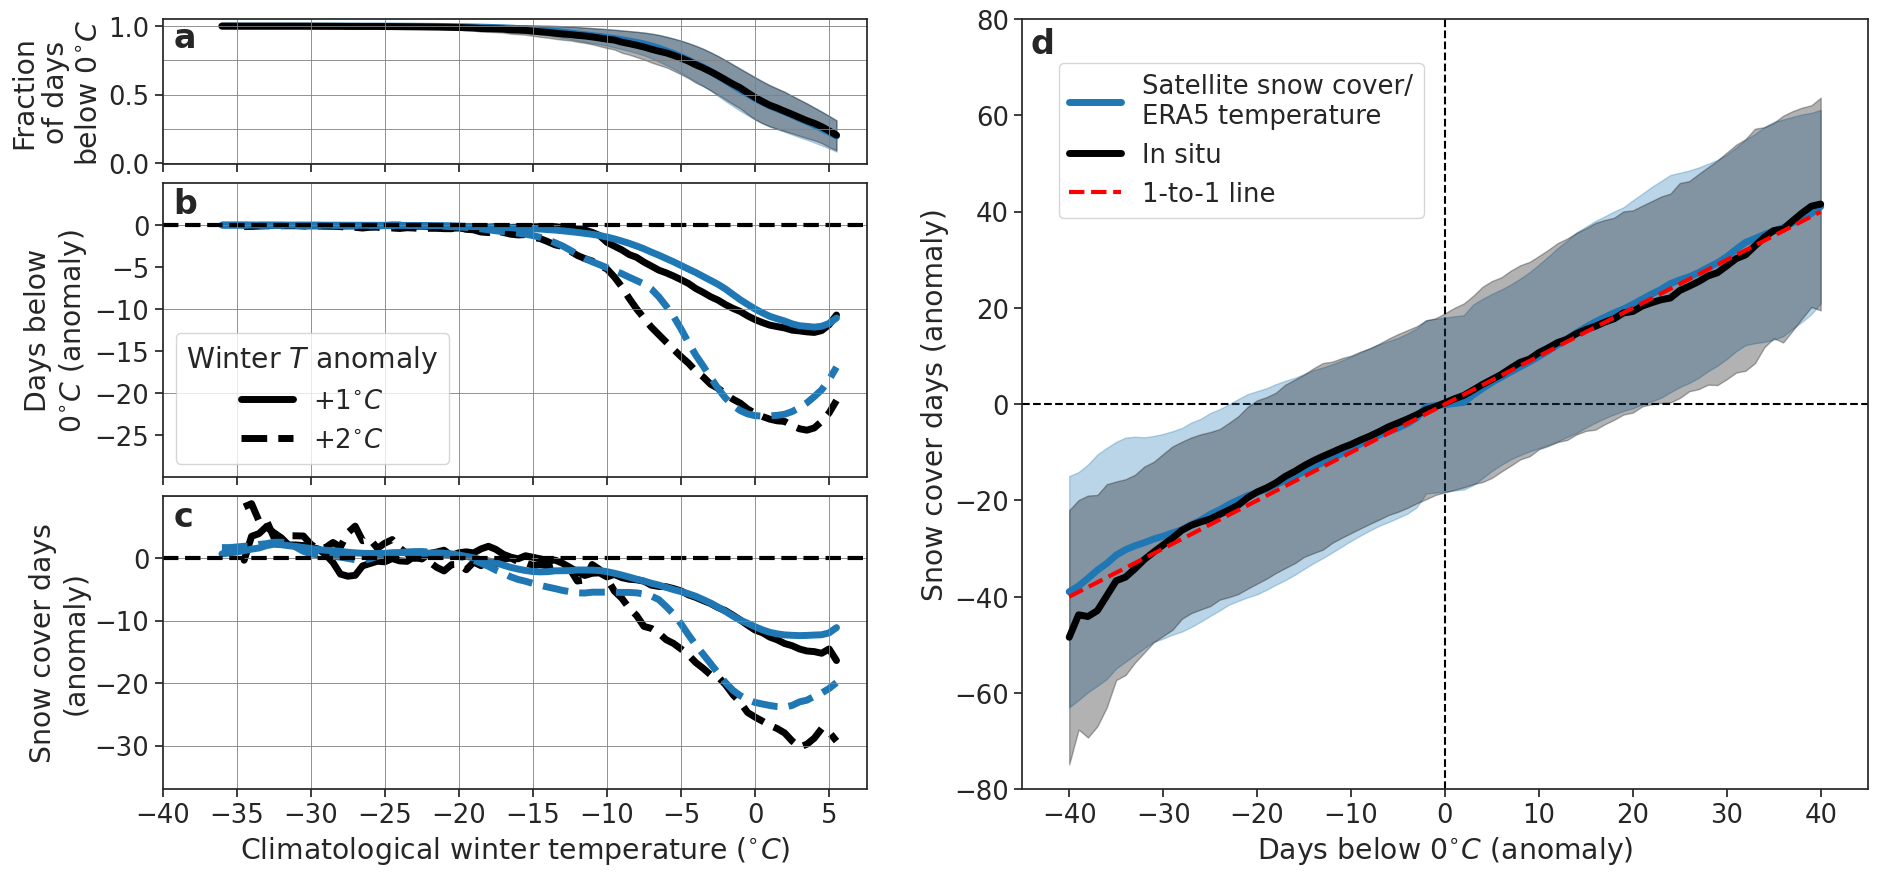

In [28]:
sns.set(style='ticks',font_scale=1.7)
fig = plt.figure(figsize=(22,10))
gs = gridspec.GridSpec(nrows=7,ncols=2,height_ratios=[1.7,1,1,1,1,1,1],width_ratios=[1,1.2],figure=fig)
ax1 = plt.subplot(gs[0,0])
ax1.plot(ts,era5_cold_means,lw=5,color='tab:blue')
ax1.fill_between(ts,era5_cold_lower,era5_cold_upper,color='tab:blue',alpha=0.3)
ax1.plot(ts,insitu_cold_means,lw=5,color='black',label='In situ')
ax1.fill_between(ts,insitu_cold_lower,era5_cold_upper,color='black',alpha=0.3)
ax1.set_ylabel("Fraction\nof days\nbelow $0^{\circ}C$")
ax1.set_ylim(-0.01,1.05)
ax1.set_yticks([0,0.5,1])
ax1.set_xticks(np.linspace(-40,5,10))
ax1.set_xticklabels([])
# ax1.legend(bbox_to_anchor=(0.7,0.99))
ax1.text(0.015,0.985,'a',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax1.transAxes)
xmin,xmax = ax1.get_xlim()
ax1.hlines(np.arange(0,1.1,0.25),xmin=xmin,xmax=xmax,color='grey',lw=0.6)

ax2 = plt.subplot(gs[1:4,0])
ax2.plot(ts,insitu_plus1_means['cold_days_anom'],color='black',lw=5,label='$+1^{\circ}C$')
ax2.plot(ts,insitu_plus2_means['cold_days_anom'],color='black',lw=5,linestyle='--',label='$+2^{\circ}C$')

ax2.plot(ts,era5_plus1_means['cold_days_anom'],color='tab:blue',lw=5)
ax2.plot(ts,era5_plus2_means['cold_days_anom'],color='tab:blue',lw=5,linestyle='--')

ax2.set_ylabel("Days below\n"+r"$0^{\circ}C$"+" (anomaly)")
ax2.set_ylim(-30,5)
ax2.set_yticks([-25,-20,-15,-10,-5,0])
ax2.set_xticks(np.linspace(-40,5,10))
ax2.set_xticklabels([])
ax2.hlines(np.arange(-30,11,10),xmin=xmin,xmax=xmax,color='grey',lw=0.6)
ax2.axhline(0,color='black',linestyle='--',lw=3)
ax2.legend(title='Winter $T$ anomaly', loc='lower left')
ax2.text(0.015,0.985,'b',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax2.transAxes)

ax3 = plt.subplot(gs[4:,0])
ax3.plot(ts,insitu_plus1_means['sc_anom'],color='black',lw=5,label='$+1^{\circ}C$')
ax3.plot(ts,insitu_plus2_means['sc_anom'],color='black',lw=5,linestyle='--',label='$+2^{\circ}C$')

ax3.plot(ts,era5_plus1_means['sc_anom'],color='tab:blue',lw=5)
ax3.plot(ts,era5_plus2_means['sc_anom'],color='tab:blue',lw=5,linestyle='--')

ax3.set_ylabel("Snow cover days"+"\n(anomaly)")
ax3.set_ylim(-37,10)
ax3.set_yticks(np.arange(-30,1,10))
ax3.set_xticks(np.linspace(-40,5,10))

ax3.hlines(np.arange(-30,11,10),xmin=xmin,xmax=xmax,color='grey',lw=0.6)
ax3.axhline(0,color='black',linestyle='--',lw=3)
ax3.set_xlabel("Climatological winter temperature ($^{\circ}C$)")
ax3.text(0.015,0.985,'c',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax3.transAxes)


ax4 = plt.subplot(gs[:,1])
ax4.plot(cold,era5_cold_sc_means,color='tab:blue',lw=5,label='Satellite snow cover/\nERA5 temperature')
ax4.fill_between(cold,era5_cold_sc_lower,era5_cold_sc_upper,color='tab:blue',alpha=0.3)
ax4.plot(cold,insitu_cold_sc_means,color='black',lw=5,label='In situ')
ax4.fill_between(cold,insitu_cold_sc_lower,insitu_cold_sc_upper,color='black',alpha=0.3,)
ax4.plot([-40,40],[-40,40],color='red',linestyle='--',lw=3,label='1-to-1 line')
ax4.set_xlabel(r"Days below $0^{\circ}C$ (anomaly)")
ax4.set_ylabel("Snow cover days (anomaly)")
ax4.text(0.01,0.99,'d',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax4.transAxes)
# ax4.text(20,-40,f'y={np.round(era5_reg.params[0],3)}x',color='tab:blue')
# ax4.text(20,-47,f'y={np.round(insitu_reg.params[0],3)}x',color='black')

ax4.legend(bbox_to_anchor=(0.49,0.96))
ax4.axhline(0,color='black',linestyle='--',zorder=0)
ax4.axvline(0,color='black',linestyle='--',zorder=0)
ax4.set_xlim(-45,45)
ax4.set_ylim(-80,80)

for ax in [ax1,ax2,ax3]:
    ymin,ymax=ax.get_ylim()
    ax.vlines(np.arange(-35,6,5),ymin=ymin,ymax=ymax,color='grey',lw=0.6)
    ax.set_xlim(xmin,xmax)

plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','png','onetoone.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','pdf','onetoone.pdf'),bbox_inches='tight',dpi=350)
plt.show()